In [1]:
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import intersection, intersection_all, difference, union_all, union
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PlotPolygon
from matplotlib.patches import Rectangle
from random import random, randrange
from math import comb, dist
from itertools import combinations

### Define create functions

In [2]:
## Make circle function as polygon
def Circle(x, y, radius):
    return Point(x,y).buffer(radius)


### Define process function

In [3]:
def getIntersectRegions(polygons): ## polygons is the list of all polygon
    return_list = []

    for iteration in range (len (polygons)):
        temp_return_list = return_list
        combo_list = list(combinations(polygons, len(polygons)-iteration))
        for combo in combo_list:
            temp = intersection_all(combo)
            if not temp.is_empty:
                temp = difference(temp, union_all(temp_return_list, grid_size = 0.005), grid_size = 0.009)
            if not temp.is_empty:
                if type(temp) == MultiPolygon:
                    area_list = [poly.area for poly in temp.geoms]
                    temp = temp.geoms[area_list.index(max(area_list))]       
                return_list.append(temp)

    
    return return_list

In [4]:
def ExcludeTableRegion(regions):
    table = Polygon(((-1,-0.5),(-1, 0.5),(1, 0.5),(1,-0.5)))
    results = []
    for region in regions:
        result = difference(region, table.buffer(0.3))
        if not result.is_empty:
            if type(result) == MultiPolygon:
                for poly in result.geoms:
                    results.append(poly)
            else:
                results.append(result)
        
    return results


In [5]:
def LinkRegionAndPlate(regions: list , Plates:list): # Plates is a list of Plates, while regions are polygons    
    Regions = []
    for region in regions:
        r = Region(region)
        for plate in Plates:
            if dist(r.center, plate.center) <=1:
                r.member_plate.append(plate)
                plate.intersect_regions.append(r)
        Regions.append(r)
        
    return Regions

In [6]:
def getNearestPlate(point, plates):
    
    for (i, plate) in enumerate(plates):
        if i == 0:
            nearest = plate
            nearest_dist = dist(plate.center, point)
        else:
            distance = dist(plate.center, point)
            if distance < nearest_dist:
                nearest = plate
                
    return nearest, nearest_dist

### Visualise Function

In [7]:
def randomColor():
    r = random()
    g = random()
    b = random()
    return (r,g,b)

def visualiseScene(polygons = [], points = [], table = False):
    colors = []
    fig, ax = plt.subplots(figsize = (9,6))
    ax.set_xlim([-3, 3])
    ax.set_ylim([-2, 2])
    ax.set_title('Shapely Polygons Visualization')

    # Draw polygons
    for polygon in polygons:
        if not polygon.is_empty:
        # color
            ax.add_patch(PlotPolygon(xy=polygon.exterior.coords, edgecolor='black', facecolor=randomColor(), alpha = 0.5))
        
        # grey
        # ax.add_patch(PlotPolygon(xy=polygon.exterior.coords, edgecolor='black', facecolor='black', alpha = 0.1))
    
    
    # Draw Rectangle (Table)
    if table:
        ax.add_patch(PlotPolygon(xy=Polygon(((-1,-0.5),(-1, 0.5),(1, 0.5),(1,-0.5))).exterior.coords, edgecolor='black', facecolor='white', alpha = 1))
    
    # Draw points
    for point in points:
        plt.scatter(point[0],point[1], color ="black")      
        

    plt.show()

### Load in intial test scene data

In [8]:
class Region:
    def __init__(self, poly:Polygon):
        self.poly = poly
        self.x = poly.centroid.x
        self.y = poly.centroid.y
        self.center = (self.x, self.y)
        self.area = poly.area
        self.member_plate = []
        

In [9]:
class Plate:
    def __init__(self, x=0, y=0, radius=1, id=0):
        self.id = id
        self.x = x
        self.y = y
        self.radius = radius
        self.center = (x,y)
        self.polygon = Circle(x,y,radius)
        self.intersect_regions = []

def CreatePlateScene(coords): # coords is list of (x,y) of plate, e.g. [(1,2),(2,4),(5,1)]
    plates = []
    for (i, plate) in enumerate(coords):
        plates.append(Plate(plate[0],plate[1],1, i))

    return plates

plate_coords = [    
        (0.69136,-0.03378),
        (0.46042,-0.31386),
        (0.23854,0.22787),
        (-0.07518,-0.28684),
        (-0.20048,0.13328),
        (0.63731,0.25367),
        (0.21473,0.04484),
        (-0.69118,-0.27422),
        (-0.824,0.26879),
        (-0.39502,-0.31306),
        (-0.5668,0.13019)
        ]

plates = CreatePlateScene(plate_coords)

# for plate in plates:
#     print (f"x = {plate.x}")
#     print (f"y = {plate.y}")
#     print (f"center = {plate.center}")
#     print()  

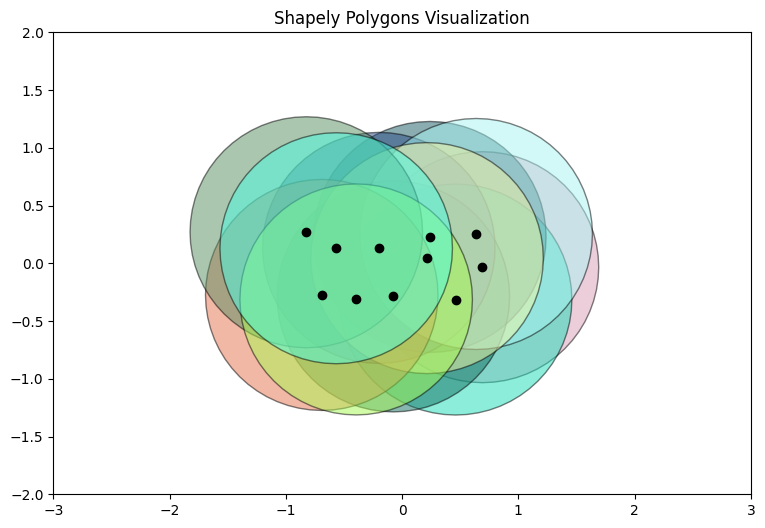

In [10]:
poly_list = [plate.polygon for plate in plates]
centers_list = [plate.center for plate in plates]
visualiseScene(poly_list, centers_list)

### 1. Get all the overlapping region as a possible node 

In [11]:
x = getIntersectRegions(poly_list)
z = ExcludeTableRegion(x)


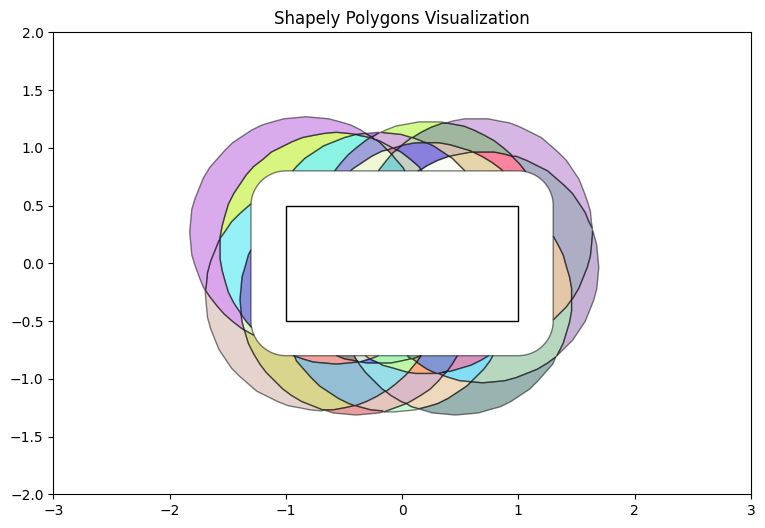

In [12]:
visualiseScene(z,table=True)

In [13]:
Z = LinkRegionAndPlate(z, plates)

### 2. Search for first node 
#### a. From start select nearest plate

In [14]:
start_point = (0.0,-1.5)

Nearest Plate id       : 9
Nearest Plate Center   : (-0.39502, -0.31306)
Nearest distance       : 1.6210427933894898


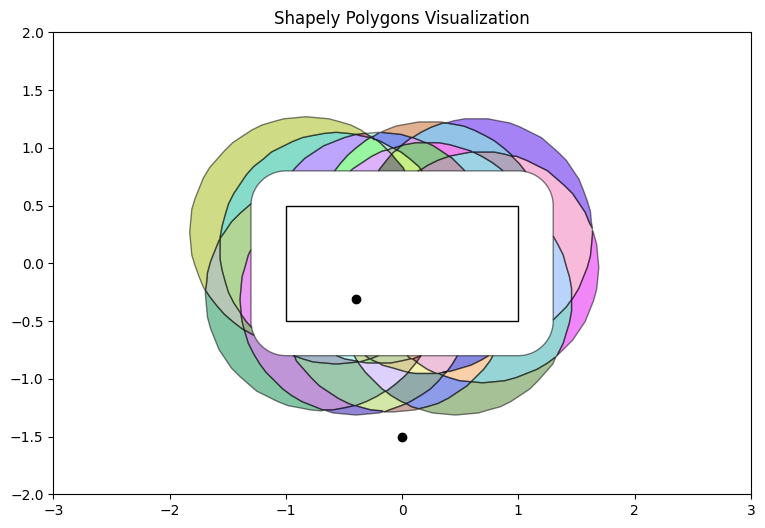

In [39]:
n1, d1 = getNearestPlate(start_point, plates)
print (f'Nearest Plate id       : {n1.id}')
print (f'Nearest Plate Center   : {n1.center}')
print (f'Nearest distance       : {d1}')
visualiseScene(polygons=z,points=[start_point, n1.center], table=True)

#### b. Get the region linked to the current plate and has most link to other plates

In [77]:
def getBestRegion(plate:Plate):
    n = 0
    for (i, region) in enumerate(plate.intersect_regions):
        if i == n:
            if region.area < 0.01:
                n+=1
                continue
            max_plate_region = region
            max_plate_qty = len(region.member_plate)
            
        else:
            plate_qty = len(region.member_plate)
            if plate_qty > max_plate_qty  and region.area >= 0.01:
                max_plate_region = region
                max_plate_qty = len(region.member_plate) 
    
    return max_plate_region, max_plate_qty, max_plate_region.area

In [86]:
best_region, best_region_qty, best_region_area = getBestRegion(n1)

print(f"Max Plate Region Center :{best_region.center}")
print(f"Max Plate Quantity      :{best_region_qty}")
print(f"Max Plate Region Area   :{best_region_area}")



Max Plate Region Center :(-0.10481757705218195, -0.8287369341877734)
Max Plate Quantity      :6
Max Plate Region Area   :0.01638499999999999


In [87]:
das = [plate.center for plate in best_region.member_plate]

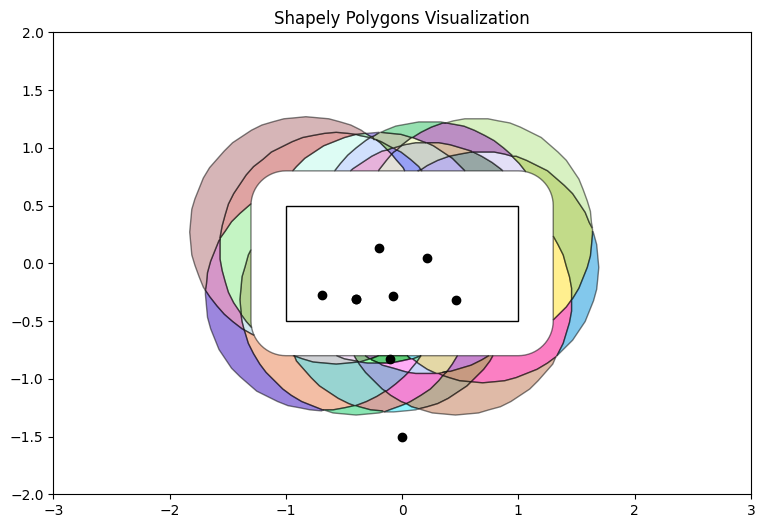

In [90]:
# visualiseScene(points=das, table=True)
visualiseScene(polygons = [max_plate_region.poly]+z ,points = [max_plate_region.center, start_point, n1.center]+das, table=True)